# 2-Sample Tests Power over Increasing Sample Size

These are same useful functions to import. Since we are calculating the statistical power over all the tests for all the simulations, we can just use a wild card import from the respective modules

In [24]:
import sys, os
import multiprocessing as mp
from joblib import Parallel, delayed

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from benchmarks import power_2samp_sample
from hyppo.independence import CCA, Dcorr, HHG, Hsic, RV, MGC
from hyppo.sims import *

sys.path.append(os.path.realpath('..'))

These are some constants that are used in this notebook. If running these notebook, please only manipulate these constants if you are not running more tests. They define the sample sizes tested upon and the number of replications. The simulations tested over and the independence tests tested over are defined also.

In [25]:
from rpy2.robjects import Formula, numpy2ri
from rpy2.robjects.packages import importr


class Manova:
    r"""
    Wrapper of R MANOVA
    """
    def __init__(self):
        self.stats = importr('stats')
        self.r_base = importr('base')
        
        numpy2ri.activate()

        self.formula = Formula('X ~ Y')
        self.env = self.formula.environment

    def _statistic(self, x, y):
        r"""
        Helper function to calculate the test statistic
        """
        self.env['Y'] = y
        self.env['X'] = x

        stat = self.r_base.summary(self.stats.manova(self.formula), test="Pillai")[3][4]

        return stat

In [26]:
MAX_SAMPLE_SIZE = 100
STEP_SIZE = 5
SAMP_SIZES = range(5, MAX_SAMPLE_SIZE + STEP_SIZE, STEP_SIZE)
POWER_REPS = 5

In [44]:
SIMULATIONS = {
    "linear": "Linear",
    "exponential": "Exponential",
    "cubic": "Cubic",
    "joint_normal": "Joint Normal",
    "step": "Step",
    "quadratic": "Quadratic",
    "w_shaped": "W-Shaped",
    "spiral": "Spiral",
    "uncorrelated_bernoulli": "Bernoulli",
    "logarithmic": "Logarithmic",
    "fourth_root": "Fourth Root",
    "sin_four_pi": "Sine 4\u03C0",
    "sin_sixteen_pi": "Sine 16\u03C0",
    "square": "Square",
    "two_parabolas": "Two Parabolas",
    "circle": "Circle",
    "ellipse": "Ellipse",
    "diamond": "Diamond",
    "multiplicative_noise": "Multiplicative",
    "multimodal_independence": "Independence"
}

# SIMULATIONS = [
#     circle
# ]

TESTS = [
    MGC,
    Dcorr,
    Hsic,
    Manova,
    HHG,
    CCA,
    RV,
]

The following function calculates the estimated power ``POWER_REPS`` number off times and averages them. It does this iterating over the number of sample sizes.

**Note: We only recommend running this code if running the next 2 cells ONCE to generate the csv files used to visualize the plots. This code takes a very long time to run and if running, we recommend using a machine with many cores.**

In [39]:
RENAME_TESTS = {
    "Dcorr": "Energy",
    "Hsic": "MMD"
}

def estimate_power(sim, test):
    est_power = np.array([np.mean([power_2samp_sample(test, rot_2samp, sim, n=i, noise=True) for _ in range(POWER_REPS)])
                          for i in SAMP_SIZES])
    np.savetxt('../benchmarks/2samp_vs_samplesize/{}_{}.csv'.format(sim.__name__, test.__name__),
               est_power, delimiter=',')
    
    return est_power

In [40]:
outputs = Parallel(n_jobs=-1, verbose=100)(
    [delayed(estimate_power)(sim, test) for sim in SIMULATIONS for test in TESTS]
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 20.8min
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed: 20.8min finished


In [41]:
sns.set(color_codes=True, style='white', context='talk', font_scale=1.5)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE[1:5] + PALETTE[6:], n_colors=9)

In [45]:
def plot_power():
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(25,20))
    
    plt.suptitle("Multivariate Three-Sample Testing Increasing Sample Size", y=0.93, va='baseline')
    
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            count = 5*i + j
            sim = list(SIMULATIONS.keys())[count]
            
            for test in TESTS:
                test_name = test.__name__
                power = np.genfromtxt('../benchmarks/2samp_vs_samplesize/{}_{}.csv'.format(sim, test_name),
                                      delimiter=',')
                manova_power = np.genfromtxt('../benchmarks/2samp_vs_samplesize/{}_Manova.csv'.format(sim), delimiter=',')

                if test_name == "MGC":
                    col.plot(SAMP_SIZES, power - manova_power, color="#e41a1c", label=test_name, lw=4)
                elif test_name == "Manova":
                    col.plot(SAMP_SIZES, power - manova_power, label=test_name, lw=4, linestyle='dashed')
                else:
                    col.plot(SAMP_SIZES, power - manova_power, label=test_name, lw=2)
                col.set_xticks([])
                if i == 3:
                    col.set_xticks([SAMP_SIZES[0], SAMP_SIZES[-1]])
                col.set_ylim(-1.05, 1.05)
                col.set_yticks([])
                if j == 0:
                    col.set_yticks([-1, 0, 1])
                col.set_title(SIMULATIONS[sim])
    
    fig.text(0.5, 0.08, 'Sample Size', ha='center')
    fig.text(0.08, 0.5, 'Statistical Power Relative to Manova', va='center', rotation='vertical')
    leg = plt.legend(bbox_to_anchor=(0.5, 0.07), bbox_transform=plt.gcf().transFigure,
                     ncol=len(TESTS), loc='upper center')
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(5.0)
    plt.subplots_adjust(hspace=.50)
    plt.savefig('../benchmarks/figs/2samp_power_sampsize.pdf', transparent=True, bbox_inches='tight')

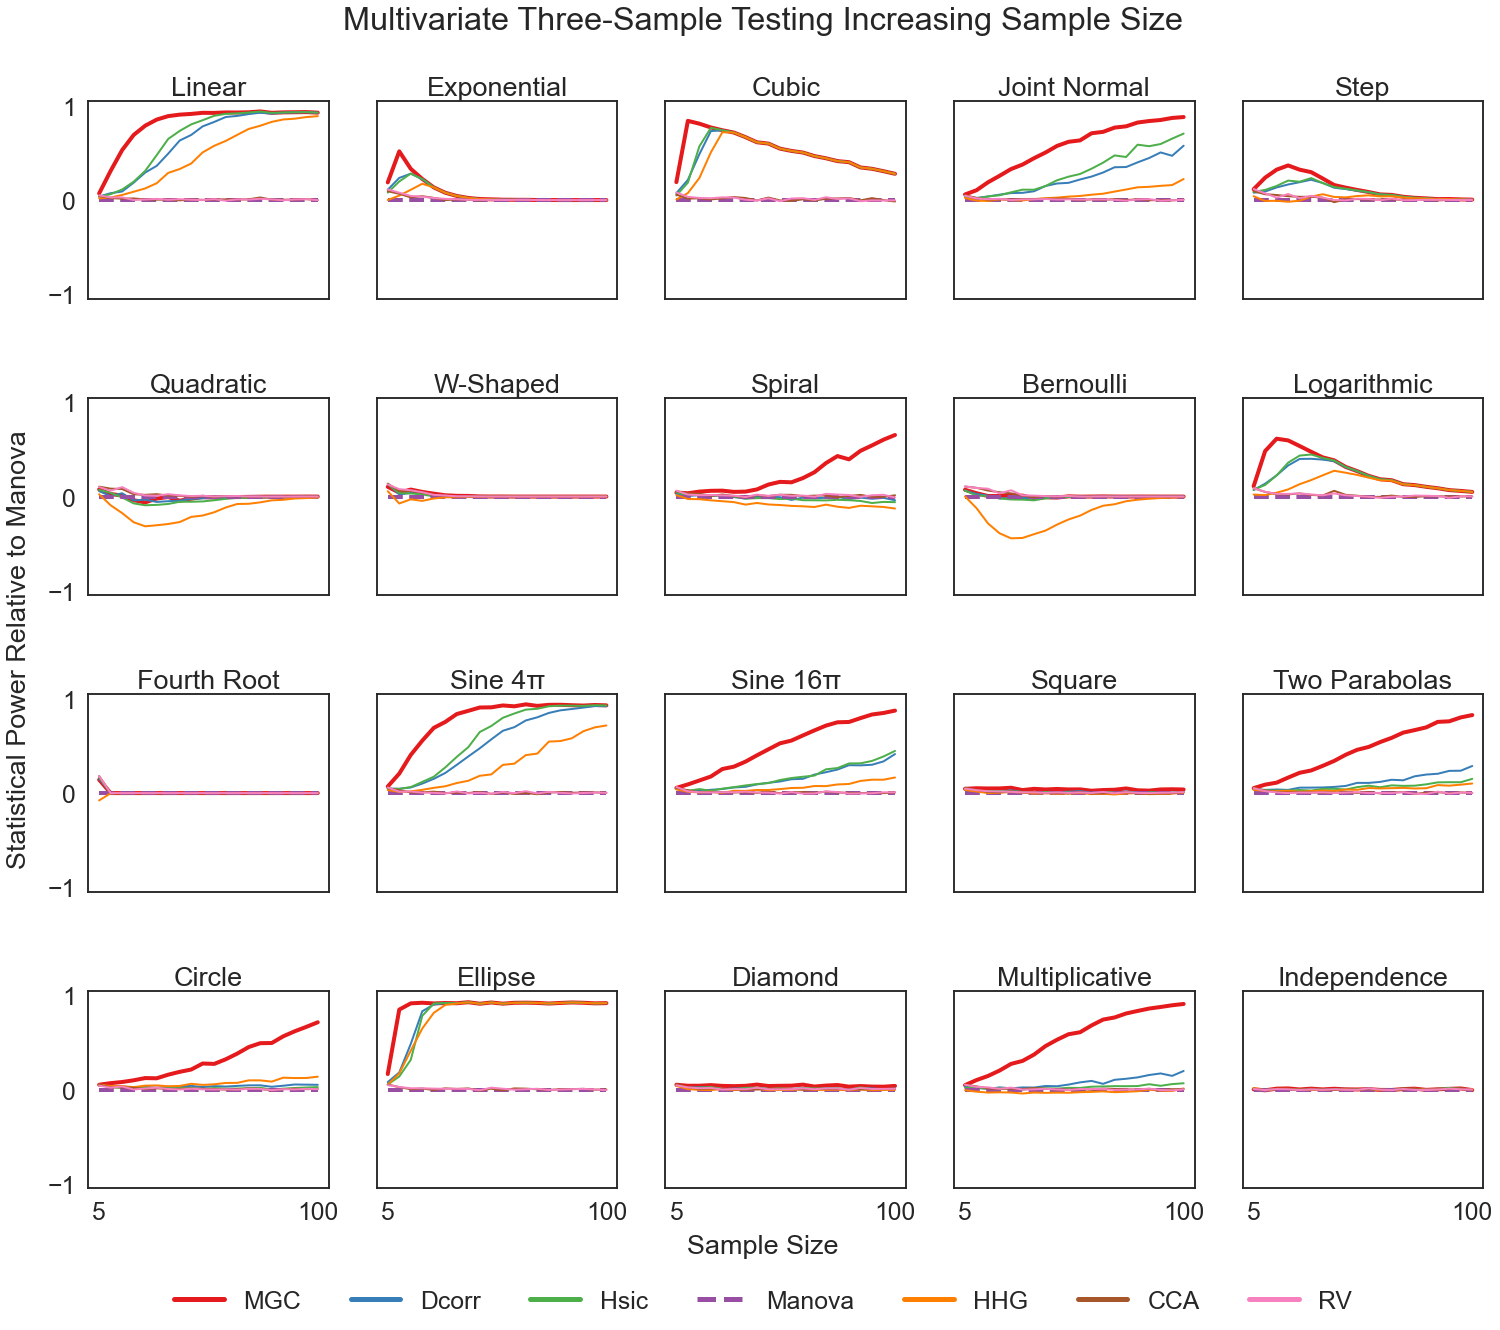

In [46]:
plot_power()

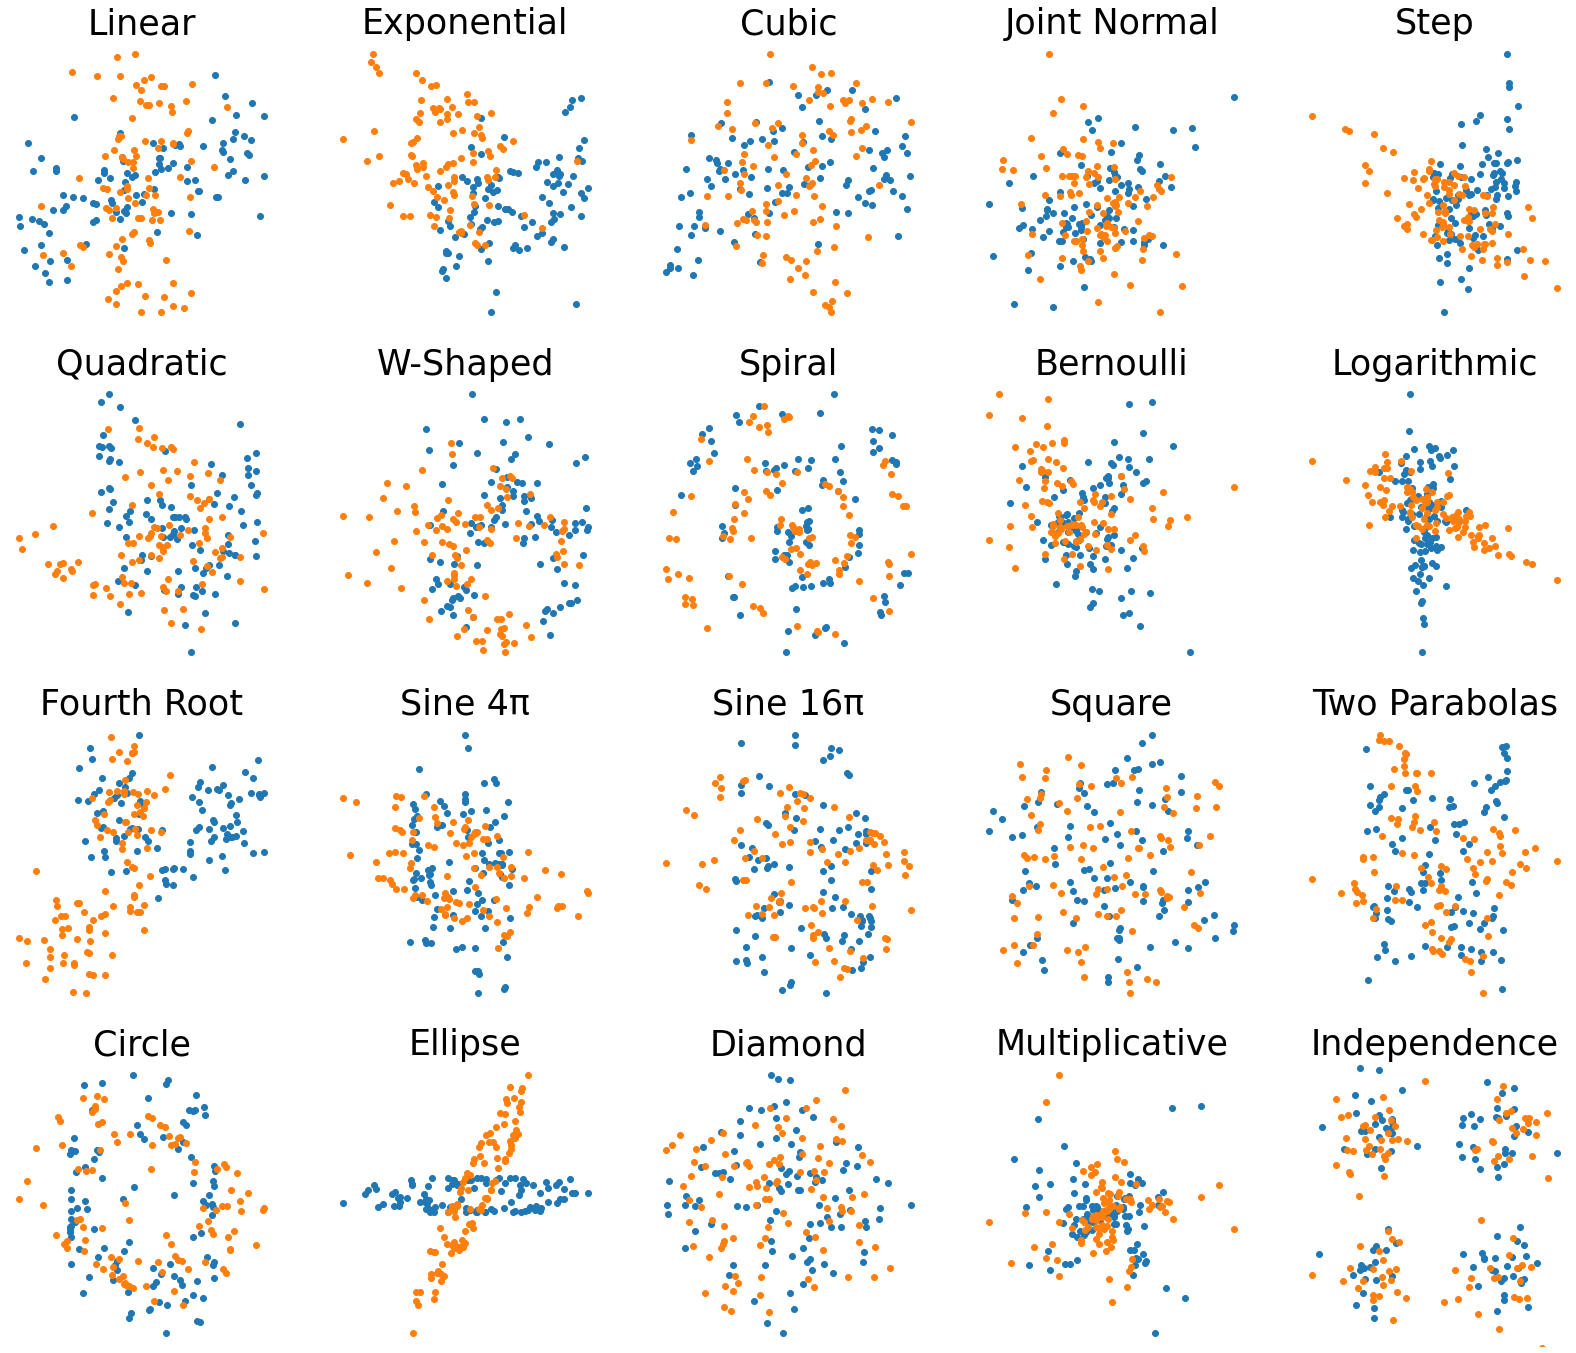

In [23]:
N = 100
P = 1
DEGREE = 60

def _normalize(x, y):
    """Normalize input data matricies."""
    x = x / np.max(np.abs(x))
    y = y / np.max(np.abs(y))
    return x, y


def _2samp_rotate(sim, x, y, p, degree=90, pow_type="samp"):
    angle = np.radians(degree)
    data = np.hstack([x, y])
    same_shape = [
        "joint_normal",
        "logarithmic",
        "sin_four_pi",
        "sin_sixteen_pi",
        "two_parabolas",
        "square",
        "diamond",
        "circle",
        "ellipse",
        "multiplicative_noise",
        "multimodal_independence",
    ]
    if sim.__name__ in same_shape:
        rot_shape = 2 * p
    else:
        rot_shape = p + 1
    rot_mat = np.identity(rot_shape)
    if pow_type == "dim":
        if sim.__name__ not in [
            "exponential",
            "cubic",
            "spiral",
            "uncorrelated_bernoulli",
            "fourth_root",
            "circle",
        ]:
            for i in range(rot_shape):
                mat = np.random.normal(size=(rot_shape, 1))
                mat = mat / np.sqrt(np.sum(mat ** 2))
                if i == 0:
                    rot = mat
                else:
                    rot = np.hstack([rot, mat])
                rot_mat, _ = np.linalg.qr(rot)
                if (p % 2) == 1:
                    rot_mat[0] *= -1
        else:
            rot_mat[np.ix_((0, -1), (0, -1))] = np.array(
                [[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]]
            )
    elif pow_type == "samp":
        rot_mat[np.ix_((0, 1), (0, 1))] = np.array(
            [[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]]
        )
    else:
        raise ValueError("pow_type not a valid flag ('dim', 'samp')")
    rot_data = (rot_mat @ data.T).T

    if sim.__name__ in [
        "joint_normal",
        "logarithmic",
        "sin_four_pi",
        "sin_sixteen_pi",
        "two_parabolas",
        "square",
        "diamond",
        "circle",
        "ellipse",
        "multiplicative_noise",
        "multimodal_independence",
    ]:
        x_rot, y_rot = np.hsplit(rot_data, 2)
    else:
        x_rot, y_rot = np.hsplit(rot_data, [-1])

    return x_rot, y_rot

indep_sims = [
    (linear, "Linear"),
    (exponential, "Exponential"),
    (cubic, "Cubic"),
    (joint_normal, "Joint Normal"),
    (step, "Step"),
    (quadratic, "Quadratic"),
    (w_shaped, "W-Shaped"),
    (spiral, "Spiral"),
    (uncorrelated_bernoulli, "Bernoulli"),
    (logarithmic, "Logarithmic"),
    (fourth_root, "Fourth Root"),
    (sin_four_pi, "Sine 4\u03C0"),
    (sin_sixteen_pi, "Sine 16\u03C0"),
    (square, "Square"),
    (two_parabolas, "Two Parabolas"),
    (circle, "Circle"),
    (ellipse, "Ellipse"),
    (diamond, "Diamond"),
    (multiplicative_noise, "Multiplicative"),
    (multimodal_independence, "Independence")
]

fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(28,24))
for i, row in enumerate(ax):
    for j, col in enumerate(row):
        count = 5*i + j
        sim, sim_title = indep_sims[count]
        if sim.__name__ == "multimodal_independence":
            x1, y1 = sim(N, P)
            x2, y2 = sim(N, P)
        else:
            if sim.__name__ == "multiplicative_noise":
                x1, y1 = sim(N, P)
            else:
                x1, y1 = sim(N, P, noise=True)
            if sim.__name__ not in ["linear", "exponential", "cubic"]:
                pass
            else:
                x1, y1 = _normalize(x1, y1)
            x2, y2 = _2samp_rotate(sim, x1, y1, P, degree=DEGREE, pow_type="samp")
        col.scatter(x1, y1, label="Orginal Sample")
        col.scatter(x2, y2, label="Rotated Sample")
        col.set_title('{}'.format(sim_title), fontsize=35)
        col.set_xticks([])
        col.set_yticks([])
        if sim.__name__ == "multimodal_independence":
            col.set_ylim([-2, 2])
        sns.despine(left=True, bottom=True, right=True)